In [1]:
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import helper

import matplotlib as mpl
import pickle
from copy import deepcopy
import time
from graphviz import Digraph
import itertools
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pandas as pd
import seaborn as sns
from scipy.stats import multivariate_normal

### Generate data from 2 tasks

In [2]:
def sokatmondo_adat():
  alpha = 90 #x-esek eloszor
  sigma_r = .3
  gamma = helper.gamma_from_alpha(alpha)
  Tx = 3
  z_prior = tfd.MultivariateNormalDiag(loc=[-1,1], scale_diag=[.3,.3]);
  z = np.array(z_prior.sample(Tx))
  r_noise = tfd.Normal(0, .001).sample(Tx)
  r_mean = tf.reduce_sum(tf.multiply(gamma,z),1)
  r = r_mean + r_noise
  datax = {'z':z,'r':r}

  alpha = 0 #utana y-osok
  gamma = helper.gamma_from_alpha(alpha)
  Ty = 3
  z_prior = tfd.MultivariateNormalDiag(loc=[-1,1], scale_diag=[.3,.3]);
  z = np.array(z_prior.sample(Ty))
  r_noise = tfd.Normal(0, .001).sample(Ty)
  r_mean = tf.reduce_sum(tf.multiply(gamma,z),1)
  r = r_mean + r_noise
  datay = {'z':z,'r':r}

  data = concatenate_data(datax, datay)
  z = data['z']
  r = np.array(data['r'])

  xylabels = ['x']*Tx + ['y']*Ty
  return z, r, xylabels

def concatenate_data(data1, data2):
  z = np.concatenate((data1['z'], data2['z']), 0)
  r = np.concatenate((np.array(data1['r']), np.array(data2['r'])))
  return {'z': z, 'r': r}

def plot_data_xy_labels(data, labels):
    plt.scatter(*data['z'].T,c=data['r'])
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.xlabel('z_1')
    plt.ylabel('z_2')
    plt.axhline(y = 0)
    plt.axvline(x = 0)
    for label, x, y in zip(labels, data['z'][:, 0], data['z'][:, 1]):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-20, 20),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

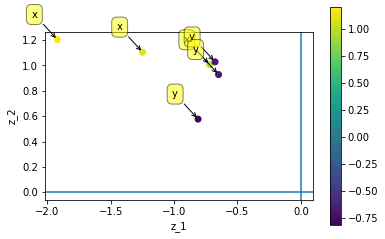

In [3]:
N = 2**2 # particleok szama
sigma_r = .3
z, r, xylabels = sokatmondo_adat()
data1 = {'z':z, 'r':r}
plot_data_xy_labels(data1, xylabels)

### Fit 2D 1 task model [(?)](https://www.notion.so/EM-meeting-344e2ac8dfdb45bb916d844de3cd4ca5#5a462ae58c1a47339f0e0cf0c01a4e41)


In [13]:
posterior_params = helper.gamma_posterior_analytic(data1['z'], data1['r'], sigma_r, Sigma_0=10*np.eye(2))

In [14]:
posterior = tfd.MultivariateNormalFullCovariance(loc=posterior_params[0], covariance_matrix=posterior_params[1])


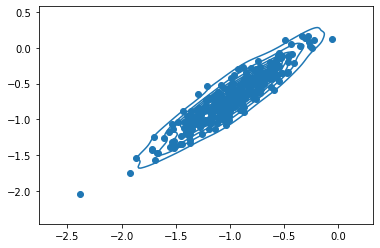

In [6]:
samples = posterior.sample(300)
sns.kdeplot(x=samples[:, 0], y=samples[:, 1])
plt.scatter(x=samples[:, 0], y=samples[:, 1])
samples = posterior.sample(10)


### Generate dream data from posterior

In [7]:
def generate_data_from_posterior_samples(N=100, gamma=0, z_prior_type='uniform', sigma_z_prior=1, r_bias=0, sigma_reward=0.1, sigma_bias=0):
    if z_prior_type == 'normal':
        z_prior = tfd.MultivariateNormalDiag(loc=[0,0], scale_diag=[sigma_z_prior,sigma_z_prior]);
    elif z_prior_type == 'uniform':
        z_prior = tfd.Uniform([0,0],[sigma_z_prior,sigma_z_prior])

    z = np.array(z_prior.sample(N))

    r_noise = tfd.Normal(0, sigma_reward).sample(N)
    r_mean = tf.cast(tf.reduce_sum(tf.multiply(gamma,z),1),dtype=tf.float32) + r_bias
    r = r_mean + r_noise

    return z[0],r[0]

In [20]:
def generate_dream_data_from_posterior_samples(samples):
  z_samples = []
  r_samples = []

  for gamma_sample in samples:
      # generate a single datapoint for each gamma sample
      z,r = generate_data_from_posterior_samples(N=1, gamma=gamma_sample, z_prior_type='uniform', sigma_reward=0.1)
      z_samples.append(z)
      r_samples.append(r)

  z_samples = np.array(z_samples)
  r_samples = np.array(r_samples)

  return {'z': np.array(z_samples), 'r': np.array(r_samples)}

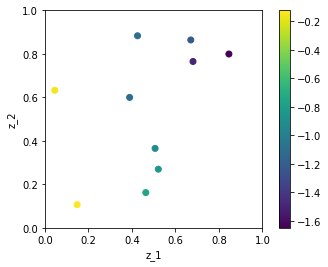

In [37]:
dream_data = generate_dream_data_from_posterior_samples(samples)
helper.plot_data(dream_data, labels=False)

### Compute mllh for 1 task and 2 task models on dream data

In [42]:
# mllh on 2D 1 task model
# there is one of these in helper and one of these defined in particle_filter.ipynb
# helper.compute_log_mllh_by_gamma(z, r, gamma_samples, sigma_reward)
helper.model_marginal_llh_analytic(dream_data['z'], dream_data['r'], sigma_r, Sigma_0=np.eye(2))

0.10187222136220794

In [46]:
# mllh on 2D 2 task model
# these are from particle_filter.ipynb but is it correct to just mllh?

from itertools import chain, combinations
def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def model_marginal_llh_analytic(zs, rs, sigma_r, Sigma_0 = np.array([[1., 0.], [0., 1.]]), model = '2d'):
    # this is the model marginal likelihood function
    # it is validated through 'trial_nonorm_posterior_set_transformed'
    # from that function the only step fowrad is to leave the normal in gamma (the gamma posterior) since gamma is marginalized out
    if zs.size != 0:
      T = np.size(zs,0)
      if model == '2d':
        assert not np.isscalar(Sigma_0), 'Sigma_0 must be a 2-dimensional array'
        detSigma_0 = np.linalg.det(Sigma_0)
        Sigma_i_star_invs = []
        Sigma_i_invs = []
        mu_is = []
        y = 1/(2*np.pi)/np.sqrt(np.linalg.det(Sigma_0))
        for t in range(T):
            z = zs[t]
            r = rs[t]
            Sigma_i_star_inv = np.array([[z[0]**2/sigma_r**2, z[0]*z[1]/sigma_r**2],[z[0]*z[1]/sigma_r**2, z[1]**2/sigma_r**2]])
            Sigma_i_star_invs.append(Sigma_i_star_inv)
            if t==0:
                Sigma_i_inv = Sigma_i_star_inv + np.linalg.inv(Sigma_0)
            else:
                Sigma_i_inv = Sigma_i_star_inv + Sigma_i_invs[t-1]
            Sigma_i_invs.append(Sigma_i_inv)
            Sigma_i = np.linalg.inv(Sigma_i_inv)
            if t==0:
                mu_i = Sigma_i.dot(z*r/sigma_r**2)
            else:
                mu_i = Sigma_i.dot(z*r/sigma_r**2 + Sigma_i_invs[t-1].dot(mu_is[t-1]))
            mu_is.append(mu_i)
            y = y * multivariate_normal.pdf(r, mean = 0, cov = sigma_r**2)
        y = y / multivariate_normal.pdf(mu_i, mean = np.array([0,0]), cov = Sigma_i)
      else:
        '''
        Sigma_0 is the standard deviation of the gamma prior
        '''
        assert np.isscalar(Sigma_0), 'Sigma_0 must be scalar'
        if model == 'x':
          integral_dim = 1
        else:
          integral_dim = 0

        Sigma_i_star_invs = []
        Sigma_i_invs = []
        mu_is = []
        y = 1/(np.sqrt(2*np.pi))/Sigma_0
        for t in range(T):
            z = zs[t]
            r = rs[t]
          
            Sigma_i_star_inv = z[integral_dim]**2/sigma_r**2
            Sigma_i_star_invs.append(Sigma_i_star_inv)
            if t==0:
                Sigma_i_inv = Sigma_i_star_inv + 1/Sigma_0**2
            else:
                Sigma_i_inv = Sigma_i_star_inv + Sigma_i_invs[t-1]
            Sigma_i_invs.append(Sigma_i_inv)
            Sigma_i = 1/Sigma_i_inv
            if t==0:
                mu_i = Sigma_i * z[integral_dim]*r/sigma_r**2
            else:
                mu_i = Sigma_i * (z[integral_dim]*r/sigma_r**2 + Sigma_i_invs[t-1]*mu_is[t-1])
            mu_is.append(mu_i)
            y = y * multivariate_normal.pdf(r, mean = 0, cov = sigma_r**2)
        y = y / multivariate_normal.pdf(mu_i, mean = 0.0, cov = Sigma_i)

      return y
    else:
      return 1.

def model_marginal_llh_analytic_2x2D(z, r, sigma_r, Sigma_0_2D = np.array([[1., 0.], [0., 1.]]), verbose = True):
  T = z.shape[0]
  
  indices = np.arange(T)
  index_subsets = list(powerset(indices))

  mmllh_accumulator = 0.
  if verbose:
    pbar = tf.keras.utils.Progbar(len(index_subsets))
  for index_subset in index_subsets:
    z1 = z[list(index_subset)]
    r1 = r[list(index_subset)]
    
    complementer_subset = [item for item in indices if item not in index_subset]
    
    z2 = z[complementer_subset]
    r2 = r[complementer_subset]
    
    mmllh_accumulator += model_marginal_llh_analytic(z1, r1, sigma_r, Sigma_0 = Sigma_0_2D, model = '2d') \
    * model_marginal_llh_analytic(z2, r2, sigma_r, Sigma_0 = Sigma_0_2D, model = '2d')
    
    if verbose:
      pbar.add(1)
      
  mmllh_accumulator /= 2**T
  return mmllh_accumulator

In [47]:
model_marginal_llh_analytic_2x2D(dream_data['z'], dream_data['r'], sigma_r, Sigma_0_2D = np.array([[1., 0.], [0., 1.]]))

1024/1024 [==============================] - 2s 2ms/step


0.011303782930335288